## Shopper Hiring Problem

#### Author: David Tan
#### Feb 19, 2022

### Context
 - In this simulated dataset, we have been running an A/B test on our shopper hiring funnel to see if initiating the required applicant background check earlier in the process would improve conversion rates. The theory is that shoppers will maintain their momentum and be more likely to start (and start more quickly) if the required pre-requisties are complete faster. 
 - The background check costs us 30 dollars to complete. A shopper must both activate the prepaid debit card we mail to them (to use when paying for groceries purchased for our customers) and have successfully passed their background check to complete their first batch of orders. Completing the online orientation, however, is optional. 
 - In this scenario, "success" for our shopper recruiting funnel is achieved if they complete their first batch (see "first_batch_completed_date")
 
### Questions
 - Based on this data, what can we conclude at this point from the A/B test (in which we tried initiating the background check earlier in the hiring process for the treatment shoppers)? And how confident should we be in this conclusion?
 - We'd like to know if this change is cost-effective. How should we think about the cost effectiveness or return on investment of this change? And what if the cost of the backgorund check was actually 50 dollars, or 100 dollars (instead of 30 dollars)?


### Read in data

First, let's take a look at the data and find the most appropriate DS method to this problem. 

In [1]:
#Import required libraries:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches #for custom legends
import seaborn as sns
from lifelines import KaplanMeierFitter #survival analysis library
from lifelines.statistics import logrank_test #survival statistical testing
from lifelines import CoxPHFitter
%matplotlib inline

In [2]:
# Read the data:
data = pd.read_csv("shopper.csv")
data.head()

,applicant_id,channel,group,city,event,event_date
0,10001,web-search-engine,control,Asgard,application_date,10/1/18
1,10002,social-media,control,Midgard,application_date,10/1/18
2,10003,web-search-engine,treatment,Midgard,application_date,10/1/18
3,10004,social-media,treatment,Asgard,application_date,10/1/18
4,10005,social-media,treatment,Midgard,application_date,10/1/18


In [3]:
data.tail()

,applicant_id,channel,group,city,event,event_date
108323,29128,web-search-engine,treatment,Asgard,first_batch_completed_date,11/11/18
108324,29161,web-search-engine,treatment,Vanaheim,first_batch_completed_date,11/10/18
108325,29167,shopper-referral-bonus,treatment,Jotunheim,first_batch_completed_date,11/11/18
108326,29170,shopper-referral-bonus,treatment,Alfheim,first_batch_completed_date,11/11/18
108327,29274,shopper-referral-bonus,treatment,Asgard,first_batch_completed_date,11/11/18


In [4]:
# Check dimension and column types:
data.shape, data.dtypes

((108328, 6),
 applicant_id     int64
 channel         object
 group           object
 city            object
 event           object
 event_date      object
 dtype: object)

In [5]:
# check unique values:
for i in data.columns:
    print(data[i].unique())

[10001 10002 10003 ... 31696 31697 31698]
['web-search-engine' 'social-media' 'job-search-site'
 'shopper-referral-bonus']
['control' 'treatment']
['Asgard' 'Midgard' 'Helheim' 'Alfheim' 'Jotunheim' 'Niflheim' 'Vanaheim'
 'Muspelheim' 'Svartalfheim']
['application_date' 'card_mailed_date' 'orientation_completed_date'
 'card_activation_date' 'background_check_initiated_date'
 'background_check_completed_date' 'first_batch_completed_date']
['10/1/18' '10/2/18' '10/3/18' '10/4/18' '10/5/18' '10/6/18' '10/7/18'
 '10/8/18' '10/9/18' '10/10/18' '10/11/18' '10/12/18' '10/13/18'
 '10/14/18' '10/15/18' '10/16/18' '10/17/18' '10/18/18' '10/19/18'
 '10/20/18' '10/21/18' '10/22/18' '10/23/18' '10/24/18' '10/25/18'
 '10/26/18' '10/27/18' '10/28/18' '10/29/18' '10/30/18' '10/31/18'
 '11/1/18' '11/2/18' '11/3/18' '11/4/18' '11/5/18' '11/6/18' '11/7/18'
 '11/8/18' '11/9/18' '11/10/18' '11/11/18']


In [6]:
# check missing or NaN
data.isnull().values.any()

False

In [7]:
# check the original sample sizes
control_size = data[(data['group'] == 'control') & (data['event'] == 'application_date')].applicant_id.count()
treatment_size = data[(data['group'] == 'treatment') & (data['event'] == 'application_date')].applicant_id.count()
print('control sample size: ', control_size)
print('treatment sample size: ', treatment_size)
print('control : treatment:', control_size/treatment_size, ': 1')

control sample size:  14501
treatment sample size:  7197
control : treatment: 2.0148673058218702 : 1


The ratio of control to treatment is 2 : 1. When the control group is big, the power of the study is increased which can detect a significant difference. 

In [8]:
# check study beginning date for both control and treatment
print(data[(data['group'] == 'control') & (data['event'] == 'application_date')].event_date.unique(), 
data[(data['group'] == 'treatment') & (data['event'] == 'application_date')].event_date.unique())

['10/1/18' '10/2/18' '10/3/18' '10/4/18' '10/5/18' '10/6/18' '10/7/18'
 '10/8/18' '10/9/18' '10/10/18' '10/11/18' '10/12/18' '10/13/18'
 '10/14/18' '10/15/18' '10/16/18' '10/17/18' '10/18/18' '10/19/18'
 '10/20/18' '10/21/18' '10/22/18' '10/23/18' '10/24/18' '10/25/18'
 '10/26/18' '10/27/18' '10/28/18' '10/29/18' '10/30/18' '10/31/18'
 '11/1/18' '11/2/18' '11/3/18' '11/4/18' '11/5/18' '11/6/18' '11/7/18'
 '11/8/18' '11/9/18' '11/10/18' '11/11/18'] ['10/1/18' '10/2/18' '10/3/18' '10/4/18' '10/5/18' '10/6/18' '10/7/18'
 '10/8/18' '10/9/18' '10/10/18' '10/11/18' '10/12/18' '10/13/18'
 '10/14/18' '10/15/18' '10/16/18' '10/17/18' '10/18/18' '10/19/18'
 '10/20/18' '10/21/18' '10/22/18' '10/23/18' '10/24/18' '10/25/18'
 '10/26/18' '10/27/18' '10/28/18' '10/29/18' '10/30/18' '10/31/18'
 '11/1/18' '11/2/18' '11/3/18' '11/4/18' '11/5/18' '11/6/18' '11/7/18'
 '11/8/18' '11/9/18' '11/10/18' '11/11/18']


This shows that shoppers enter our study from different dates. Their onboarding process are different in terms of time. Different shoppers have different "background_check_initiated_date" and "first_batch_completed_date". 

### Methdology

After scanning the data, we can conclude that it is a "time-to-event analysis". In our case, we can use survival analysis to find out the time it takes for an applicant to convert to a real shopper. Our question becomes "Do we convert more applicants to shoppers and convert more faster if we perform a new hiring strategy (required applicant background check earlier in the process)?"

In this case study, we want to find the number of days until a shopper completed the first batch. We are also interested in which group (control or treatment) completed the first batch faster. It's tempting to think that the lower the survival rate, the faster shoppers completing the first batch. Therefore, we perform the following analysis to answer the two questions:

 - What is the probability that a shopper 'survives' (i.e. hasn't completed the first batch) a specific period?
 - Are there differences in survival curve between control and treatment?

We will rely on the following methods:

(1) Kaplan-Meier plots to visualize survival curves.

(2) Nelson-Aalen plots to visualize the cumulative hazard.

(3) Log-rank test to compare the survival curves of two groups. 

As mentioned, survival analysis focuses on the occurrence of an event of interest (completing the first batch). But it's possible that the event may not be ovserved for various reasons. Such observations are known as censored observations. 

Censoring may arise from (1) A shopper has not yet delivered the first batch within out study period. (2) A shopper is not being followed anymore (i.e. move to other places). This type of censoring, called right censoring, is handled in our analysis. Right censoring derives its name from the fact that time is typically displayed from left to right.

Now, it's time to implement the theory from the above.

### Organize data

We first need to organize our data. Notice that the final conversion funnel is "first_batch_completed_date" but there are several intermediate events between application and completing the first batch. **We are interested to learn the impact from the intermediate events on the final conversion rate.** Hence, we will perform sub-tests to compare the survival curves and estimate hazards for each event.   

We add new columns to store the data about whether a applicant has encountered each event and the number of days since submitting the application. 

In [9]:
# change event_date to datetime
data['event_date'] = pd.to_datetime(data['event_date'])

# transpose df: vertical events to horizon 
data_trans = pd.crosstab(data.applicant_id, data.event)
data_trans = pd.merge(data.loc[data['event'] == 'application_date'], data_trans, on = 'applicant_id')
data_trans.rename(columns = {'application_date': 'application_indicator',
                'card_mailed_date': 'card_mailed',
                'orientation_completed_date': 'orientation_completed',
                'card_activation_date': 'card_activated',
                'background_check_initiated_date': 'background_check_initiated',
                'background_check_completed_date': 'background_check_completed',
                'first_batch_completed_date': 'first_batch_completed'}, inplace=True)

In [10]:
# compute study duration - right censoring time
study_period = max(data[data['event'] == 'first_batch_completed_date']["event_date"]) - \
                min(data[data['event'] == 'application_date']["event_date"])

# compute days since application for each event until first_batch_completed
events = ['card_mailed_date', 'orientation_completed_date', 'card_activation_date', 'background_check_initiated_date',
'background_check_completed_date', 'first_batch_completed_date']

for event in events:
    df = pd.DataFrame(data.pivot('applicant_id','event','event_date').\
            assign(days_diff = lambda x: x[event] - x['application_date'])['days_diff'])
    col_name = event[:-4] + 'days'
    df.rename(columns = {'days_diff':col_name}, inplace = True)
    df[col_name] = df[col_name].dt.days
    df[col_name].fillna(study_period.days, inplace=True)
    data_trans = pd.merge(data_trans, df, on = "applicant_id")

In [11]:
# compute days between background check initiated and background check completed
df = pd.DataFrame(data.pivot('applicant_id','event','event_date').\
        assign(background_check_days = lambda x: x['background_check_completed_date'] - x['background_check_initiated_date'])['background_check_days'])
df['background_check_days'] = df['background_check_days'].dt.days
df['background_check_days'].fillna(study_period.days, inplace=True)
data_trans = pd.merge(data_trans, df, on = "applicant_id")

In [12]:
# compute days between background check completed and first batch completed
df = pd.DataFrame(data.pivot('applicant_id','event','event_date').\
        assign(bc_to_first_batch_days = lambda x: x['first_batch_completed_date'] - x['background_check_completed_date'])['bc_to_first_batch_days'])
df['bc_to_first_batch_days'] = df['bc_to_first_batch_days'].dt.days
df['bc_to_first_batch_days'].fillna(study_period.days, inplace=True)
data_trans = pd.merge(data_trans, df, on = "applicant_id")

In [13]:
data_trans.head()

,applicant_id,channel,group,city,event,event_date,application_indicator,background_check_completed,background_check_initiated,card_activated,card_mailed,first_batch_completed,orientation_completed,card_mailed_days,orientation_completed_days,card_activation_days,background_check_initiated_days,background_check_completed_days,first_batch_completed_days,background_check_days,bc_to_first_batch_days
0,10001,web-search-engine,control,Asgard,application_date,2018-10-01,1,0,0,0,1,0,1,0.0,2.0,41.0,41.0,41.0,41.0,41.0,41.0
1,10002,social-media,control,Midgard,application_date,2018-10-01,1,1,1,1,1,1,0,0.0,41.0,11.0,11.0,16.0,19.0,5.0,3.0
2,10003,web-search-engine,treatment,Midgard,application_date,2018-10-01,1,1,1,1,1,0,1,1.0,4.0,3.0,0.0,7.0,41.0,7.0,41.0
3,10004,social-media,treatment,Asgard,application_date,2018-10-01,1,1,1,1,1,1,0,0.0,41.0,3.0,0.0,4.0,5.0,4.0,1.0
4,10005,social-media,treatment,Midgard,application_date,2018-10-01,1,1,1,1,1,1,1,0.0,0.0,7.0,0.0,6.0,7.0,6.0,1.0


Create an object for KaplanMeierFitter:   

In [14]:
# Create the object
# kmf_c for control group
# kmf_t for treatment group
kmf_c = KaplanMeierFitter()
kmf_t = KaplanMeierFitter()

# devide data into two groups
data_c = data_trans.loc[data_trans['group'] == "control"]
data_t = data_trans.loc[data_trans['group'] == 'treatment']

In [15]:
data_c.describe()

,applicant_id,application_indicator,background_check_completed,background_check_initiated,card_activated,card_mailed,first_batch_completed,orientation_completed,card_mailed_days,orientation_completed_days,card_activation_days,background_check_initiated_days,background_check_completed_days,first_batch_completed_days,background_check_days,bc_to_first_batch_days
count,14501.000000,14501.0,14501.000000,14501.000000,14501.000000,14501.000000,14501.000000,14501.000000,14501.000000,14501.000000,14501.000000,14501.000000,14501.000000,14501.000000,14501.000000,14501.000000
mean,20851.431556,1.0,0.652093,0.747259,0.747259,0.983794,0.198124,0.412523,1.147093,25.230053,13.796221,13.796221,19.811875,34.858561,16.834977,33.255224
std,6262.755765,0.0,0.476323,0.434599,0.434599,0.126271,0.398600,0.492305,5.139121,18.874340,15.945685,15.945685,15.626098,12.420969,17.686948,15.593028
min,10001.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,4.000000,4.000000,2.000000,0.000000
25%,15466.000000,1.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,3.000000,3.000000,3.000000,7.000000,41.000000,3.000000,41.000000
50%,20874.000000,1.0,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,41.000000,5.000000,5.000000,10.000000,41.000000,5.000000,41.000000
75%,26267.000000,1.0,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000
max,31698.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000


In [16]:
data_t.describe()

,applicant_id,application_indicator,background_check_completed,background_check_initiated,card_activated,card_mailed,first_batch_completed,orientation_completed,card_mailed_days,orientation_completed_days,card_activation_days,background_check_initiated_days,background_check_completed_days,first_batch_completed_days,background_check_days,bc_to_first_batch_days
count,7197.000000,7197.0,7197.000000,7197.0,7197.000000,7197.000000,7197.000000,7197.000000,7197.000000,7197.000000,7197.000000,7197.0,7197.000000,7197.000000,7197.000000,7197.000000
mean,20845.608170,1.0,0.887036,1.0,0.818258,0.982493,0.343338,0.468112,1.201473,23.494512,11.198416,0.0,8.107267,29.303043,8.107267,28.012783
std,6266.389334,0.0,0.316570,0.0,0.385659,0.131161,0.474856,0.499017,5.336090,18.730829,14.178626,0.0,11.811395,16.236775,11.811395,18.010276
min,10003.000000,1.0,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.0,2.000000,2.000000,2.000000,0.000000
25%,15329.000000,1.0,1.000000,1.0,1.000000,1.000000,0.000000,0.000000,0.000000,4.000000,3.000000,0.0,3.000000,8.000000,3.000000,4.000000
50%,20797.000000,1.0,1.000000,1.0,1.000000,1.000000,0.000000,0.000000,1.000000,41.000000,5.000000,0.0,4.000000,41.000000,4.000000,41.000000
75%,26289.000000,1.0,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,41.000000,8.000000,0.0,5.000000,41.000000,5.000000,41.000000
max,31691.000000,1.0,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,41.000000,41.000000,41.000000,0.0,41.000000,41.000000,41.000000,41.000000


We noticed that the background_check_initiated_dates are the same as application_dates for treatment group. 

In [39]:
# the 1st arg is a pd.Series of individual survival times
# the 2nd arg is a pd.Series that indicates if the event occured.

kmf_c.fit(durations = data_c['first_batch_completed_days'], 
          event_observed = data_c['first_batch_completed'], label = 'control')
kmf_t.fit(durations = data_t['first_batch_completed_days'], 
          event_observed = data_t['first_batch_completed'], label = 'treatment')

<lifelines.KaplanMeierFitter:"treatment", fitted with 7197 total observations, 4726 right-censored observations>

In [69]:
kmf_c.cumulative_density_

,control
timeline,
0.0,0.000000
4.0,0.000552
5.0,0.004689
6.0,0.014964
7.0,0.035170
8.0,0.063927
9.0,0.094476
10.0,0.123371
11.0,0.146955


In [71]:
kmf_t.cumulative_density_

,treatment
timeline,
0.0,0.000000
2.0,0.000973
3.0,0.010977
4.0,0.043629
5.0,0.094623
6.0,0.163124
7.0,0.227317
8.0,0.271502
9.0,0.300403


In [40]:
1 - kmf_c.predict(41)

0.19812426729191124

In [41]:
1 - kmf_t.predict(41) - (1 - kmf_c.predict(41))

0.14521323444492285

final conversion rate log-rank test results:


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         761.97 <0.005    554.76

Text(0.5, 1.0, 'total shopper conversion')

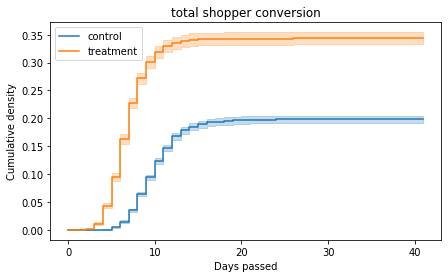

In [20]:
time_c = data_c['first_batch_completed_days']
time_t = data_t['first_batch_completed_days']
    
end_c = data_c['first_batch_completed']
end_t = data_t['first_batch_completed']
    
results = logrank_test(time_c, time_t, event_observed_A = end_c, event_observed_B = end_t)
print('final conversion rate log-rank test results:')
results.print_summary()

plt.figure(figsize=(7, 4))

kmf_c.plot_cumulative_density()
kmf_t.plot_cumulative_density()

plt.xlabel("Days passed")
plt.ylabel("Cumulative density")
plt.title('total shopper conversion')

Notice that, as the number of survival days increases, the probability of a person dying increases.

final conversion rate log-rank test for job-search-site:


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         257.05 <0.005    189.75

final conversion rate log-rank test for shopper-referral-bonus:


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         131.00 <0.005     98.35

final conversion rate log-rank test for social-media:


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          67.98 <0.005     52.43

final conversion rate log-rank test for web-search-engine:


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         389.11 <0.005    285.31

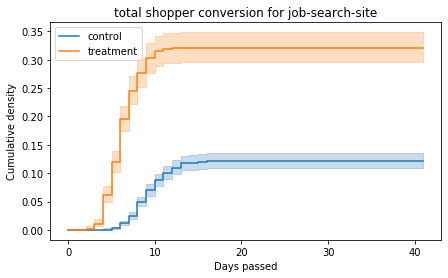

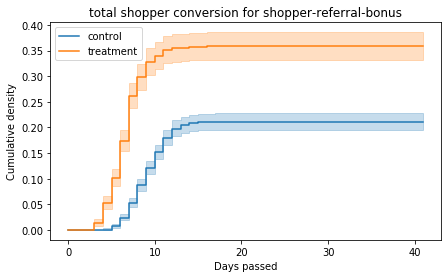

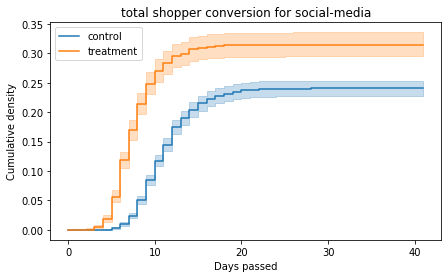

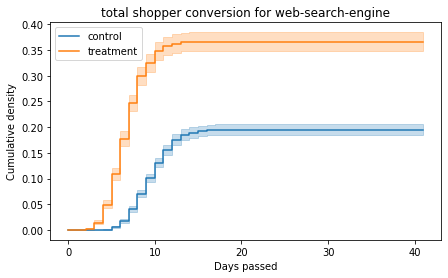

In [21]:
channels = ['job-search-site', 'shopper-referral-bonus', 'social-media', 'web-search-engine']

for channel in channels:
    kmf_c_c = KaplanMeierFitter()
    kmf_t_c = KaplanMeierFitter()

    # devide data into two groups
    data_c_c = data_trans.loc[(data_trans['group'] == "control") & (data_trans['channel'] == channel)]
    data_t_c = data_trans.loc[(data_trans['group'] == 'treatment') & (data_trans['channel'] == channel)]

    # the 1st arg is a pd.Series of individual survival times
    # the 2nd arg is a pd.Series that indicates if the event occured.
    kmf_c_c.fit(durations = data_c_c['first_batch_completed_days'], 
          event_observed = data_c_c['first_batch_completed'], label = 'control')
    kmf_t_c.fit(durations = data_t_c['first_batch_completed_days'], 
          event_observed = data_t_c['first_batch_completed'], label = 'treatment')

    plt.figure(figsize=(7, 4))

    kmf_c_c.plot_cumulative_density()
    kmf_t_c.plot_cumulative_density()

    plt.xlabel("Days passed")
    plt.ylabel("Cumulative density")
    plt.title('total shopper conversion for ' + channel)
    
    time_c_c = data_c_c['first_batch_completed_days']
    time_t_c = data_t_c['first_batch_completed_days']
    
    end_c_c = data_c_c['first_batch_completed']
    end_t_c = data_t_c['first_batch_completed']
    
    results = logrank_test(time_c_c, time_t_c, event_observed_A = end_c_c, event_observed_B = end_t_c)
    print('final conversion rate log-rank test for {}:'.format(channel))
    results.print_summary()

In [22]:
data_trans.groupby(['group','city'])['city'].count()

group      city        
control    Alfheim         1253
           Asgard          4601
           Helheim          103
           Jotunheim        203
           Midgard         6657
           Muspelheim        98
           Niflheim         519
           Svartalfheim      88
           Vanaheim         979
treatment  Alfheim          612
           Asgard          2306
           Helheim           55
           Jotunheim        103
           Midgard         3286
           Muspelheim        58
           Niflheim         295
           Svartalfheim      47
           Vanaheim         435
Name: city, dtype: int64

final conversion rate log-rank test for Alfheim:


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          47.42 <0.005     37.34

final conversion rate log-rank test for Asgard:


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         255.55 <0.005    188.67

final conversion rate log-rank test for Helheim:


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           1.38 0.24      2.06

final conversion rate log-rank test for Jotunheim:


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
           8.62 <0.005      8.23

final conversion rate log-rank test for Midgard:


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         356.23 <0.005    261.53

final conversion rate log-rank test for Muspelheim:


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           3.13 0.08      3.70

final conversion rate log-rank test for Niflheim:


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          56.62 <0.005     44.11

final conversion rate log-rank test for Svartalfheim:


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           1.25 0.26      1.93

final conversion rate log-rank test for Vanaheim:


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          41.68 <0.005     33.12

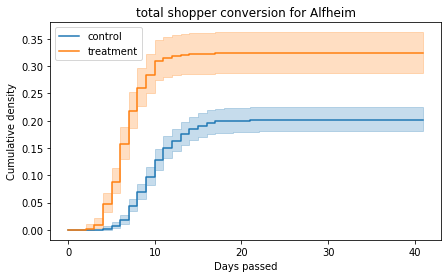

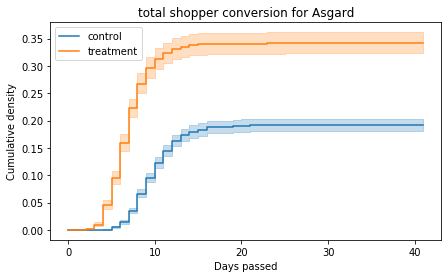

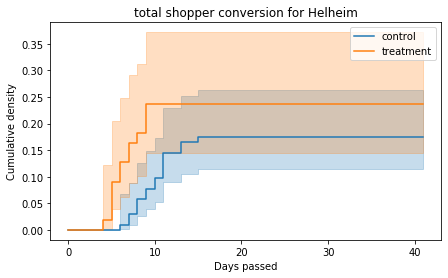

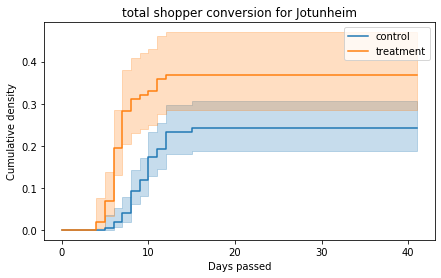

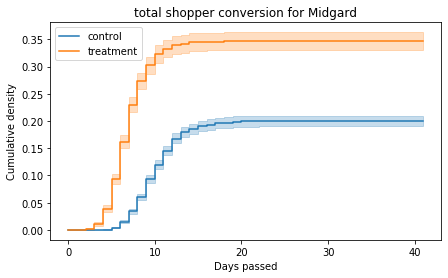

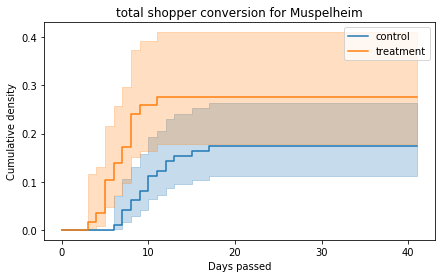

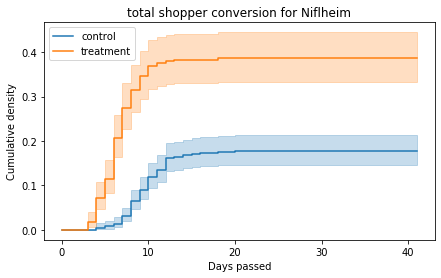

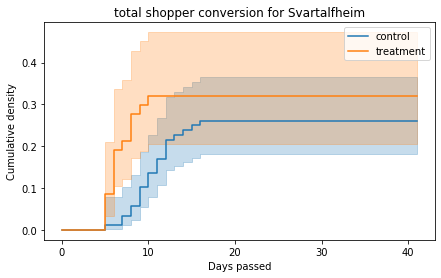

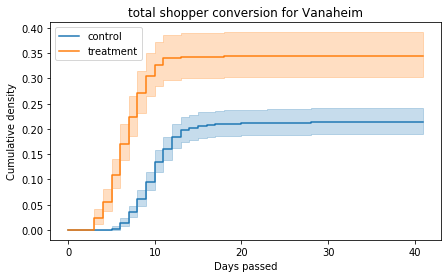

In [23]:
# some cities have very small sample size
cities = ['Alfheim', 'Asgard', 'Helheim', 'Jotunheim', 'Midgard', 'Muspelheim', 'Niflheim', 'Svartalfheim', 'Vanaheim']

for city in cities:
    kmf_c_c = KaplanMeierFitter()
    kmf_t_c = KaplanMeierFitter()

    # devide data into two groups
    data_c_c = data_trans.loc[(data_trans['group'] == "control") & (data_trans['city'] == city)]
    data_t_c = data_trans.loc[(data_trans['group'] == 'treatment') & (data_trans['city'] == city)]

    # the 1st arg is a pd.Series of individual survival times
    # the 2nd arg is a pd.Series that indicates if the event occured.
    kmf_c_c.fit(durations = data_c_c['first_batch_completed_days'], 
          event_observed = data_c_c['first_batch_completed'], label = 'control')
    kmf_t_c.fit(durations = data_t_c['first_batch_completed_days'], 
          event_observed = data_t_c['first_batch_completed'], label = 'treatment')

    plt.figure(figsize=(7, 4))

    kmf_c_c.plot_cumulative_density()
    kmf_t_c.plot_cumulative_density()

    plt.xlabel("Days passed")
    plt.ylabel("Cumulative density")
    plt.title('total shopper conversion for ' + city)
    
    time_c_c = data_c_c['first_batch_completed_days']
    time_t_c = data_t_c['first_batch_completed_days']
    
    end_c_c = data_c_c['first_batch_completed']
    end_t_c = data_t_c['first_batch_completed']
    
    results = logrank_test(time_c_c, time_t_c, event_observed_A = end_c_c, event_observed_B = end_t_c)
    print('final conversion rate log-rank test for {}:'.format(city))
    results.print_summary()

In [24]:
event_days_dict = {'card_mailed': 'card_mailed_days', 
                   'card_activated': 'card_activation_days', 
                   'orientation_completed': 'orientation_completed_days', 
                   'background_check_initiated': 'background_check_initiated_days',
                   'background_check_completed': 'background_check_completed_days',
                   'first_batch_completed': 'first_batch_completed_days'}

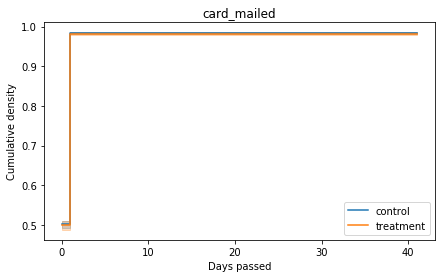

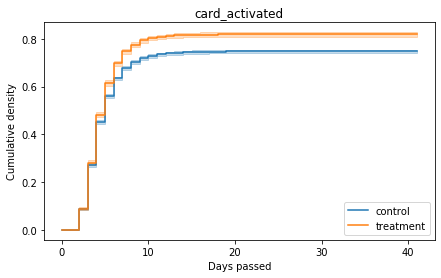

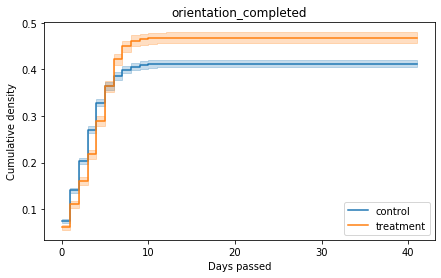

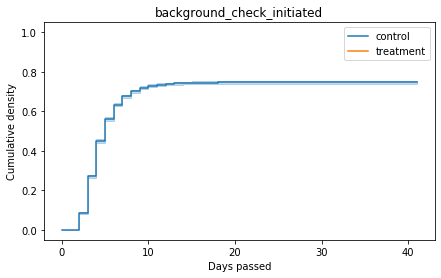

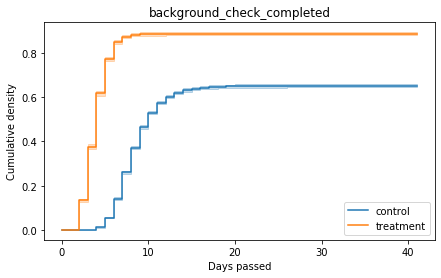

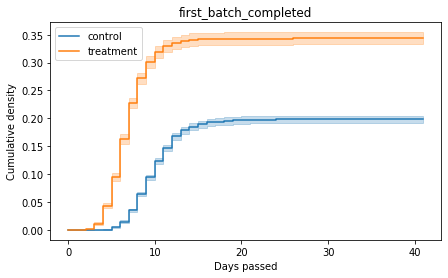

In [25]:
# create cumulative hazard plots:
for event in event_days_dict.keys():
    
    kmf_c.fit(durations = data_c[event_days_dict[event]], 
          event_observed = data_c[event], label = 'control')
    kmf_t.fit(durations = data_t[event_days_dict[event]], 
          event_observed = data_t[event], label = 'treatment')
    
    plt.figure(figsize=(7, 4))

    kmf_c.plot_cumulative_density()
    kmf_t.plot_cumulative_density()

    plt.xlabel("Days passed")
    plt.ylabel("Cumulative density")
    plt.title(event)

Log-Rank Test:



In [28]:
# define variables:

for event in event_days_dict.keys():
    time_c = data_c[event_days_dict[event]]
    time_t = data_t[event_days_dict[event]]
    
    end_c = data_c[event]
    end_t = data_t[event]
    
    results = logrank_test(time_c, time_t, event_observed_A = end_c, event_observed_B = end_t)
    print(event, "summary:")
    results.print_summary()

card_mailed summary:


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.23 0.63      0.66

card_activated summary:


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         110.02 <0.005     83.09

orientation_completed summary:


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          23.29 <0.005     19.45

background_check_initiated summary:


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
       21697.00 <0.005       inf

background_check_completed summary:


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        8628.10 <0.005       inf

first_batch_completed summary:


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         761.97 <0.005    554.76

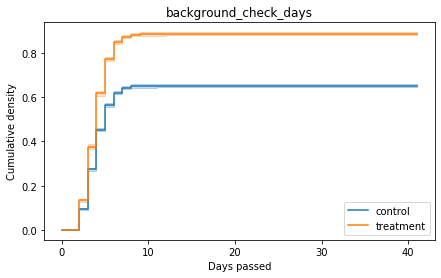

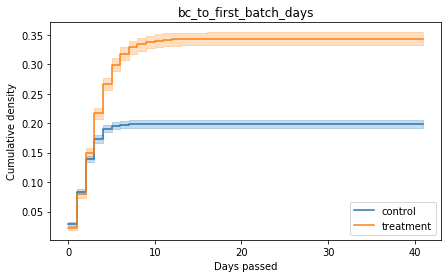

In [27]:
# create cumulative hazard plots:
for event in event_days_dict2.keys():
    
    kmf_c.fit(durations = data_c[event_days_dict2[event]], 
          event_observed = data_c[event], label = 'control')
    kmf_t.fit(durations = data_t[event_days_dict2[event]], 
          event_observed = data_t[event], label = 'treatment')
    
    plt.figure(figsize=(7, 4))

    kmf_c.plot_cumulative_density()
    kmf_t.plot_cumulative_density()

    plt.xlabel("Days passed")
    plt.ylabel("Cumulative density")
    plt.title(event_days_dict2[event])

In [26]:
event_days_dict2 = {'background_check_completed': 'background_check_days',
                    'first_batch_completed': 'bc_to_first_batch_days'}

In [29]:
# Log rank test for background check waiting period
for event in event_days_dict2.keys():
    time_c = data_c[event_days_dict2[event]]
    time_t = data_t[event_days_dict2[event]]
    
    end_c = data_c[event]
    end_t = data_t[event]
    
    results = logrank_test(time_c, time_t, event_observed_A = end_c, event_observed_B = end_t)
    print(event_days_dict2[event], "summary:")
    results.print_summary()

background_check_days summary:


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        1318.30 <0.005    956.46

bc_to_first_batch_days summary:


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         467.76 <0.005    342.18

The log-rank test is a hypothesis test to compare the survival distribution of two samples. It is widely used to establish the efficacy of a new treatment in comparison with a control treatment when the measurement is the time to event (such as the time from initial treatment to a heart attack). 

首先第一点，我们需要把所有的用户时间段对齐，把他的注册时间作为起点，实验截止时间或者drop out的时间作为终点。那么我们就会得到一大堆censored data，例子如下

Chart: Time since application in days

Arm	        User Id	Time to Event	Event  
Treatment	001	    7 days	        stay
Control	    002	    11 days	        drop out
Treatment	003	    11 days	        drop out
...	...	...	...

我们需要比较的metric应该是survival rate或者hazard rate。不懂得小伙伴可以看看survival analysis。
survival rate 的定义是，从用户注册账户，到特定时间点，用户有多大概率还在使用这个App。

然后如果我们想test survival data，一般来说有两种方法:

1. 计算一个Cox model，然后test cox model的coefficient是不是 significant
2. 用logrank test

logrank test的思想是，假设control 和 treatment的 survival rate一样。
那么在一个时间点上，treatment或者control里面，drop out users的数量应该服从一个超几何分布。
可以理解成，在某个时间天，1000个active （500 control, 500 treatment）的user中，drop out了10个user。
那么treatment arm里面的drop out的数量其实是相当于从这1000个 user 里面随机抽500个然后drop out的数量 
（因为我们假设treatment 和 control完全一样）。
在这个时间点上，我们是知道这个超几何分布的 mean 和 variance，所以我们把很多时间点的数据加起来，
用central limit theorem就可以得到一个testing statistics。

we focus on right censoring, which occurs when T >= Y, i.e. the true event time T is at least as large as the observed time Y. 
Right censoring derives its name from the fact that time is typically displayed from left to right. 

Left censoring: the true event time T is less than or equal to the observed time Y.

lifelines.utils.restricted_mean_survival_time(m,t)
You KM curve probably doesn't hit zero, so the correct answer for t=None (not specified,i.e. all time) is infinity. 
It's up to you to set a meaningful end point.

The survival curve is defined as S(t) = Pr(T>t). This decreasing function quantifies the probability of surviving beyond a given time
t. Let T represent the time that a shoper delivered the first batch. Then S(t) represents the probability that a shoper deliver
the first batch later than time t. The large the value of S(t), the less likely that the shoper will deliver the first batch before time t. 

We wish to compare the survival of males to that of females. Figure shows the Kaplan-Meier survival curves for the two groups.
The Log-Rank test is to test the equality of the two survival curves. 

Null hypothesis is no difference in survival between the two groups. When the sample size is large, the log-rank test statistic W has approximately a standard normal distribution. This can be used to compute a p-value for the null hypothesis that there is no difference between the survival curves in the two groups. 

一个A/B test的data set。要求present key findings，然后give recommendation。还有一些marketing budget的影响。
这个test的特点是 A 和 B 是两个不同的onboarding process，所以最好把整个的conversion funnel 画出来，然后给每一个step的churn rate，不要只给一个final conversion rate。
5. On-site.
a - Review take home HW. 就是把自己的finding present给interviewer。如果HW做得好，interviewer不会有太多问题。

business context很重要，我之前没有说清楚背景。
我想说的是business hypothesis比a/b test hypothesis的框架要大。一个business hypothesis可以对多个a/b test hypotheses。
这个hw的business hypothesis是缩短onboarding process可以降低churn。在这个hypothesis下，以下几个a/b test hypotheses都可以成立：. 1point3acres
H0: total churn in control = total churn in test
Ha: total churn in control > total churn in test
H0: churn of steps 1-4 in control = churn of steps 1-4 in test
Ha: churn of steps 1-4 in control > churn of steps 1-4 in test
H0: churn of steps 1-3 in control = churn of steps 1-3 in test
Ha: churn of steps 1-3 in control > churn of steps 1-3 in test
H0: churn of steps 3 in control = churn of steps 3 in test
Ha: churn of steps 3 in control > churn of steps 3 in test
H0: churn of steps 4 in control = churn of steps 4 in test
Ha: churn of steps 4 in control > churn of steps 4 in test
H0: churn of steps 5 in control = churn of steps 5 in test
Ha: churn of steps 5 in control > churn of steps 5 in test
所以才要拆开分析，进而多方面证明business hypothesis。

单从hypothesis testing的角度讲，你说的没有错。
可是从product intuition的角度讲，就会复杂一点。这个test背后的assumption是缩短onboarding process可以降低churn。
a-b-c-d-e
a-b-f-d-e
假设这两个流程的duration是
15min - 15min - 15min -15min -15min
15min - 15min - 5min -15min -15min
cumulative time是
15min - 30min - 45min - 60min - 75min
15min - 30min - 35min - 50min - 65min
第四、五的duration没有变，但是cumulative time变了。
如果相对应的churn没有变，那说明churn不被cumulative time影响。进一步说明每个步骤的churn是independent，改变第三步不影响之后的步骤。
如果相对应的churn变了，说明churn会被cumulative time影响。那么，以后应该缩短靠前的步骤的duration，这样会缩短后面每一步的cumulative time，进而reduce churn。
这样分析可以更精确地了解哪个factor在影响churn。

In [54]:
df = pd.DataFrame(data.pivot('applicant_id','event','event_date').\
        assign(days = lambda x: x['first_batch_completed_date'] - x['application_date'])['days'])
df['days'] = df['days'].dt.days
data_trans = pd.merge(data_trans, df, on = "applicant_id")

In [77]:
delta_days = data_trans.groupby(['group']).agg({'days': 'mean'})['days']['control'] - data_trans.groupby(['group']).agg({'days': 'mean'})['days']['treatment']
delta_days

3.0704817723391553

In [78]:
delta_prob = (1 - kmf_t.predict(41) - (1 - kmf_c.predict(41)))
delta_prob

0.14521323444492285

In [82]:
delta_days * 80 * 0.05 > delta_prob * 30

True

In [83]:
delta_days * 80 * 0.05 > delta_prob * 50

True

In [84]:
delta_days * 80 * 0.05 > delta_prob * 100

False